
# Aplicación Práctica: Predicción de Ingresos con Regresión Lasso
# 
##  Objetivo de la Actividad
En esta actividad práctica, aprenderemos a usar la **Regresión Lasso** para predecir el ingreso monetario de una persona. Más allá de la predicción, nuestro objetivo principal es descubrir qué características socioeconómicas son las más influyentes para determinar dicho ingreso.

### ¿Qué es la Regresión Lasso?
Es una técnica de Machine Learning que realiza dos tareas simultáneamente:
1.  **Predicción**: Crea un modelo para estimar un valor numérico (como el ingreso).
2.  **Selección de Variables**: Identifica y descarta automáticamente las variables menos importantes.

###  Hipótesis que vamos a probar:
1.  Podemos construir un modelo que explique una parte significativa de la variación en los ingresos.
2.  **Lasso** nos ayudará a identificar un subconjunto de variables clave de entre todas las disponibles en la encuesta.




In [2]:

# 📚 Importar librerías necesarias
# NumPy: Para operaciones matemáticas y arrays
import numpy as np

# Pandas: Para manipulación y análisis de datos
import pandas as pd

# Matplotlib y Seaborn: Para visualizaciones de alta calidad
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Nuestra librería principal de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

#  Configurar estilo de gráficos para que se vean más profesionales
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("✅ Librerías importadas correctamente")
print("📊 Configuración de gráficos lista")
print("🚀 ¡Listos para comenzar la actividad!")


✅ Librerías importadas correctamente
📊 Configuración de gráficos lista
🚀 ¡Listos para comenzar la actividad!



## Paso 1: Carga y Exploración de los Datos

### ¿Qué datos estamos usando?
Vamos a cargar un archivo llamado `data_processed_income_2.csv`. Este no es el archivo original de la encuesta, sino una versión que ya ha sido preparada para el modelado.
 
###  Concepto Importante: Preprocesamiento
El preprocesamiento es el conjunto de pasos que se realizan para limpiar y transformar los datos antes de dárselos a un modelo. En nuestro caso, el preprocesamiento incluyó:

1.  **Filtrado**: Se eliminaron las personas con ingreso cero para simplificar el problema.
2.  **Transformación Logarítmica**: La variable de ingreso fue transformada para que su distribución sea más simétrica, lo que ayuda a los modelos lineales.
3.  **Estandarización y Codificación**: Las variables numéricas se pusieron en la misma escala y las categóricas se convirtieron a un formato numérico.

>  **Nota:** La calidad del preprocesamiento es a menudo más importante que la elección del modelo en sí.


In [3]:

# 📂 Cargar los datos ya procesados desde el archivo CSV
try:
    data = pd.read_csv("predict_income_2020_2.csv")
    print(f"✅ Datos preprocesados cargados exitosamente.")
    print(f"📊 Dimensiones del dataset: {data.shape[0]} filas y {data.shape[1]} columnas.")
except FileNotFoundError:
    print("❌ Error: El archivo 'predict_income_2020_2.csv' no fue encontrado.")
    print("   Por favor, asegúrate de haber ejecutado primero el script de preprocesamiento.")

# 📋 Mostrar las primeras 5 filas para verificar la carga
print("\n📋 Primeras 5 filas del dataset procesado:")
display(data.head())


✅ Datos preprocesados cargados exitosamente.
📊 Dimensiones del dataset: 6193 filas y 130 columnas.

📋 Primeras 5 filas del dataset procesado:


,num__p208a_20,num__p104_20,num__p301b_20,cat__p207_20_2,cat__p110a1_20_2,cat__p1121_20_1,cat__p1124_20_1,cat__p1125_20_1,cat__p1126_20_1,cat__p1127_20_1,...,cat__p401f_20_2_1,cat__p558c_20_2_1,cat__p558c_20_3_1,cat__p558c_20_4_1,cat__p558c_20_5_1,cat__p558c_20_6_1,cat__p558c_20_7_1,cat__p558c_20_8_1,cat__p558c_20_9_1,log_ingmo2hd
0,0.892167,-0.589575,0.769687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.985195
1,-1.200039,-0.589575,-0.558632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.093405
2,0.630641,-0.007426,-2.551110,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.052985
3,0.761404,-0.589575,0.769687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.699472
4,1.022930,-0.007426,-1.222791,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.478868



## Paso 2: Preparación para el Modelado

Antes de entrenar, debemos realizar dos pasos cruciales:

1.  **Separar variables**: Distinguir entre las **variables predictoras (X)** y la **variable objetivo (y)**.
2.  **Dividir en entrenamiento y prueba**: Para evaluar de forma honesta qué tan bien generaliza nuestro modelo.

###  Conceptos Importantes:

**Variables Predictoras (X) vs. Variable Objetivo (y)**
- **X (features)**: Todas las columnas excepto `log_ingmo2hd`.
- **y (target)**: La columna `log_ingmo2hd`.

**Train-Test Split**
- **Datos de Entrenamiento (70%)**: Para "enseñarle" al modelo los patrones en los datos.
- **Datos de Prueba (30%)**: Para evaluar el rendimiento del modelo en datos "nuevos" que no ha visto durante el entrenamiento.


In [4]:

# 📊 Separar variables explicativas (X) y variable objetivo (y)
print("🔍 Separando variables predictoras (X) y objetivo (y)...")
X = data.drop('log_ingmo2hd', axis=1)
y = data['log_ingmo2hd']

print(f"📈 Variables predictoras (X): {X.shape[1]} columnas")
print(f"🎯 Variable objetivo (y): 1 columna ('log_ingmo2hd')")

# 🔄 Dividir en conjuntos de entrenamiento y prueba
print("\n🔄 Dividiendo datos en entrenamiento (70%) y prueba (30%)...")
# 'random_state=42' es una semilla que asegura que la división sea siempre la misma, haciendo nuestro experimento reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(f"📚 Datos de entrenamiento: {X_train.shape[0]} observaciones")
print(f"🧪 Datos de prueba: {X_test.shape[0]} observaciones")

print("\n✅ ¡Datos preparados y listos para entrenar el modelo!")


🔍 Separando variables predictoras (X) y objetivo (y)...
📈 Variables predictoras (X): 129 columnas
🎯 Variable objetivo (y): 1 columna ('log_ingmo2hd')

🔄 Dividiendo datos en entrenamiento (70%) y prueba (30%)...
📚 Datos de entrenamiento: 4335 observaciones
🧪 Datos de prueba: 1858 observaciones

✅ ¡Datos preparados y listos para entrenar el modelo!



## Paso 3: Entrenamiento del Modelo Lasso
 
### ¿Qué es `LassoCV`?
Usaremos `LassoCV`. Es una versión "inteligente" de Lasso que incluye **Validación Cruzada (Cross-Validation)** para encontrar el mejor parámetro de regularización de forma automática.

### 🧠 Concepto clave: El Parámetro `alpha`
Lasso tiene un parámetro llamado **alpha (α)** que controla la fuerza de la regularización:
- **α pequeño**: Poca penalización. El modelo se parece a una regresión normal.
- **α grande**: Mucha penalización. El modelo elimina más variables.

`LassoCV` prueba una gama de `alphas` y elige el que produce el mejor rendimiento predictivo.


In [ ]:

# 🚀 Entrenar el modelo Lasso con Validación Cruzada
print("🔍 Buscando el mejor parámetro alpha y entrenando el modelo Lasso...")

# 1. Definimos el modelo LassoCV
#    Le decimos que pruebe 200 valores de alpha y use 5 "folds" para la validación cruzada.
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 1, 200), cv=5, random_state=42, max_iter=2000)

# 2. Entrenamos el modelo con los datos de entrenamiento
lasso_cv_model.fit(X_train, y_train)

# 🏆 Mostrar el mejor alpha encontrado
print(f"\n🏆 Mejor alpha encontrado: {lasso_cv_model.alpha_:.5f}")
print("✅ ¡Modelo Lasso entrenado exitosamente!")


🔍 Buscando el mejor parámetro alpha y entrenando el modelo Lasso...

🏆 Mejor alpha encontrado: 0.00170
✅ ¡Modelo Lasso entrenado exitosamente!



## Paso 4: Evaluación del Desempeño del Modelo
 
Ahora que el modelo está entrenado, debemos evaluar qué tan bien funciona en el conjunto de prueba.

### 🧠 Métricas de Evaluación:
- **RMSE (Raíz del Error Cuadrático Medio)**: Nos dice, en promedio, cuál es el error de predicción en la unidad original (Soles). **Menor es mejor**.
- **R² (Coeficiente de Determinación)**: Indica qué porcentaje de la variabilidad del ingreso es explicado por nuestro modelo. **Más cercano a 1 (o 100%) es mejor**.

### 💡 Paso Crucial: Revertir la Transformación Logarítmica
Nuestro modelo predice el *logaritmo* del ingreso. Para que el error (RMSE) sea interpretable, debemos convertir las predicciones de vuelta a Soles usando la función exponencial (`np.expm1`).


In [6]:

# 📈 Hacer predicciones en datos de prueba
y_pred_log = lasso_cv_model.predict(X_test)

# 🔄 Revertir la transformación logarítmica para obtener predicciones en Soles
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# 📊 Calcular métricas de rendimiento
rmse_lasso = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_lasso = r2_score(y_test_original, y_pred_original)

print("📊 RESULTADOS DEL MODELO LASSO EN DATOS DE PRUEBA:")
print(f"💰 RMSE (Error de predicción): ${rmse_lasso:,.2f} Soles")
print(f"📈 R² (Coeficiente de determinación): {r2_lasso:.4f} (es decir, el modelo explica el {r2_lasso:.1%} de la varianza del ingreso)")


📊 RESULTADOS DEL MODELO LASSO EN DATOS DE PRUEBA:
💰 RMSE (Error de predicción): $24,774.70 Soles
📈 R² (Coeficiente de determinación): 0.3328 (es decir, el modelo explica el 33.3% de la varianza del ingreso)


Acabamos de ver que nuestro modelo tiene un **R² de 0.333** y un **RMSE de ~S/ 24,775**. A primera vista, uno podría pensar que "explicar solo el 33% es poco". Sin embargo, en el contexto de las ciencias sociales, estos resultados son muy reveladores.

### 🧠 Interpretando el R² de 0.333

Predecir el ingreso de una persona es una de las tareas más difíciles en las ciencias sociales. El ingreso no solo depende de la educación o la edad, sino de una infinidad de factores que una encuesta no puede medir:
- Habilidades blandas (negociación, liderazgo).
- Red de contactos.
- Suerte y oportunidades.
- Motivación personal.

Nuestro modelo, usando solo los datos disponibles, ha logrado explicar **un tercio de la compleja historia detrás del ingreso**. Esto significa que las variables seleccionadas por Lasso (educación, edad, etc.) tienen un poder explicativo real y significativo. El 67% restante no es un fracaso del modelo, sino un reflejo de la complejidad del comportamiento humano que no está capturada en los datos.

### 🧠 Interpretando el RMSE de ~S/ 24,775: Reduciendo la Incertidumbre

Un error promedio de S/ 24,775 al año puede parecer alto. Sin embargo, para ponerlo en perspectiva, este número debe compararse con la dispersión natural de los datos (su desviación estándar). Si la desviación estándar del ingreso es, por ejemplo, de S/ 50,000, nuestro modelo ha logrado reducir la incertidumbre a la mitad. Es mucho más preciso que simplemente usar el ingreso promedio como predicción para todos.

### 🏆 El Verdadero Valor de Nuestro Modelo Lasso

En este problema, el objetivo principal no era crear una "bola de cristal" perfecta para predecir ingresos. El verdadero valor de nuestro modelo Lasso es:

1.  **Confirmar que hay una señal predecible**: El ingreso no es completamente aleatorio; hay patrones que podemos modelar.
2.  **Realizar Selección de Variables**: Lo más importante es que Lasso nos ha dado una lista corta y manejable de las **variables más importantes**. El análisis de los **coeficientes** (Paso 5 y 6) es el resultado más valioso de este ejercicio, ya que nos orienta sobre qué factores son los más determinantes.


## Paso 5: Interpretación de Resultados
 
Esta es la parte más interesante. ¿Qué variables consideró el modelo como importantes?

### 🧠 Concepto Clave: Coeficientes del Modelo
El modelo asigna un **coeficiente** a cada variable. La magia de Lasso es que:
- Si el coeficiente es **cero**, Lasso ha **descartado** esa variable por no considerarla relevante.
- Si el coeficiente es **distinto de cero**, es una **variable seleccionada**.

**Interpretación de los coeficientes (en nuestro modelo log-level):**
- Un **coeficiente positivo** (ej: 0.10) significa que un aumento en esa variable se asocia con un aumento porcentual en el ingreso (aprox. 10%).
- Un **coeficiente negativo** (ej: -0.05) significa que un aumento en esa variable se asocia con una disminución porcentual en el ingreso (aprox. 5%).


In [7]:

# 🔍 Analizar coeficientes y selección de variables
print("🔍 Analizando los coeficientes del modelo Lasso...")

# Crear un DataFrame con los predictores y sus coeficientes
coeficientes_lasso = pd.DataFrame({
    'predictor': X.columns,
    'coef': lasso_cv_model.coef_
})

# Filtrar los coeficientes que no son cero
coeficientes_seleccionados = coeficientes_lasso[coeficientes_lasso['coef'] != 0].copy()
lasso_zero = np.sum(lasso_cv_model.coef_ == 0)

# Ordenar por el valor absoluto para ver los más importantes
coeficientes_seleccionados['importancia'] = coeficientes_seleccionados['coef'].abs()
coeficientes_seleccionados = coeficientes_seleccionados.sort_values(by='importancia', ascending=False).drop('importancia', axis=1)

print(f"\n🎯 De {len(coeficientes_lasso)} características iniciales, Lasso seleccionó {len(coeficientes_seleccionados)}.")
print(f"❌ Lasso eliminó {lasso_zero} variables al asignarles un coeficiente de cero.")

print("\n📋 Variables más importantes seleccionadas por el modelo:")
display(coeficientes_seleccionados.head(15).round(4))


🔍 Analizando los coeficientes del modelo Lasso...

🎯 De 129 características iniciales, Lasso seleccionó 65.
❌ Lasso eliminó 64 variables al asignarles un coeficiente de cero.

📋 Variables más importantes seleccionadas por el modelo:


,predictor,coef
24,cat__p501_20_2,-1.5322
32,cat__p5569a_20_2,-0.6555
118,cat__p301a_20_11_1,0.6151
26,cat__p5562a_20_2,-0.6058
62,cat__p4193_20_2,-0.4986
36,cat__p558a4_20_4,0.4206
27,cat__p5563a_20_2,-0.3903
28,cat__p5564a_20_2,-0.3813
38,cat__p558e1_1_20_1,0.3602
37,cat__p558a5_20_5,-0.3559



## Paso 6: Visualización de los Coeficientes
 
Un gráfico a menudo cuenta una historia más clara que una tabla. Vamos a visualizar los 20 coeficientes más importantes para entender de un vistazo qué factores tienen el mayor impacto en el ingreso.

### 📈 Lo que vamos a observar:
- **Barras a la derecha (positivas)**: Características que aumentan el ingreso.
- **Barras a la izquierda (negativas)**: Características que disminuyen el ingreso.
- **Longitud de la barra**: La magnitud del impacto.


C:\Users\zadel\AppData\Local\Temp\ipykernel_27640\3672933321.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='predictor', data=top_coef, palette='coolwarm')


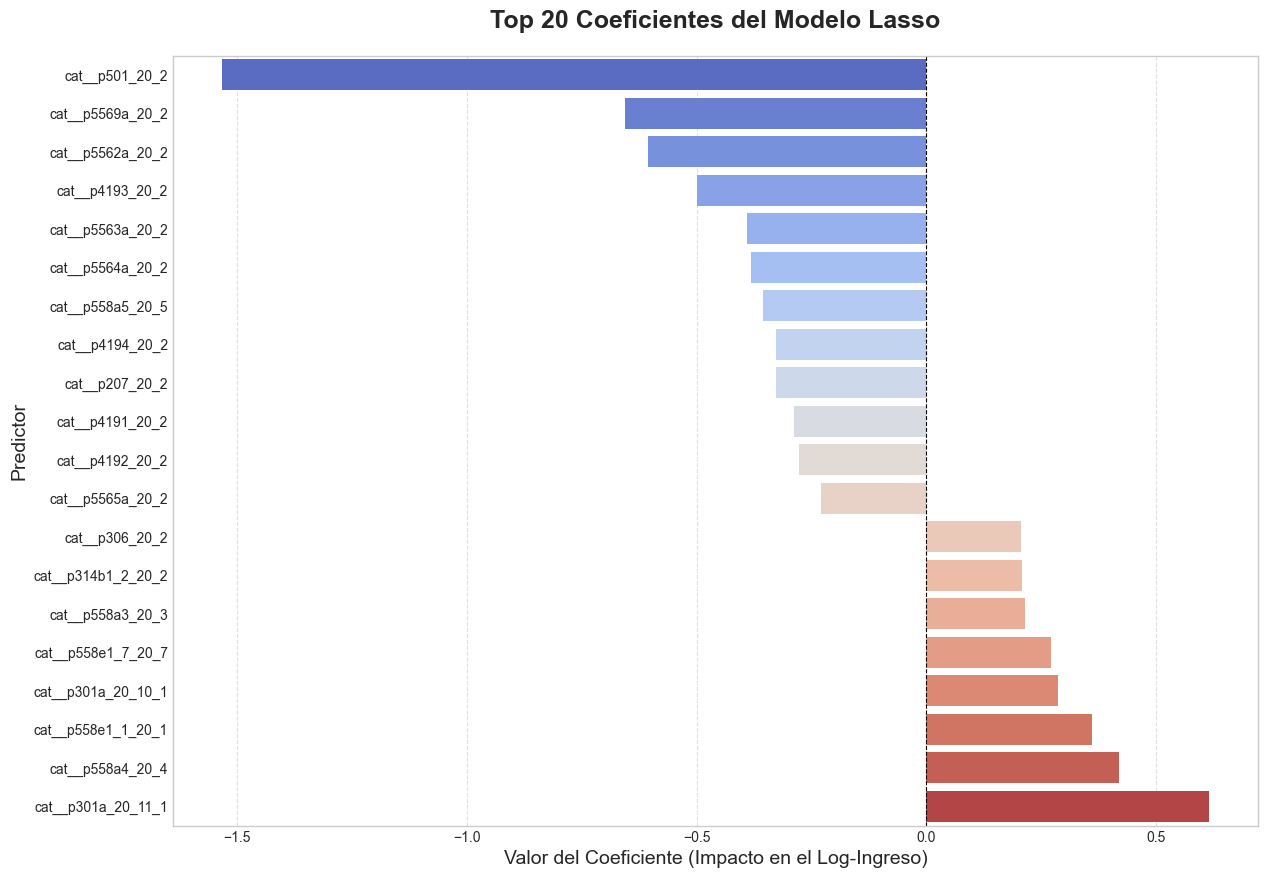

In [8]:

# 🎨 Preparando la visualización de coeficientes...

# Tomamos los 20 coeficientes con mayor valor absoluto y los ordenamos por su valor para el gráfico
top_coef = coeficientes_seleccionados.head(20).sort_values('coef')

plt.figure(figsize=(14, 10))
sns.barplot(x='coef', y='predictor', data=top_coef, palette='coolwarm')

plt.title('Top 20 Coeficientes del Modelo Lasso', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Valor del Coeficiente (Impacto en el Log-Ingreso)', fontsize=14)
plt.ylabel('Predictor', fontsize=14)
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.savefig('grafico_coeficientes_final.png')
plt.show()


### 🎯 Hallazgo 1
- **Coeficiente:** `cat__p501_20_2` = **-1.5322**
- **Variable:** Representa a las personas que **NO** tuvieron un trabajo la semana pasada.
- **Interpretación:** Las personas que no trabajaron tienen un ingreso un **78.4% menor** que las que sí lo hicieron. Este resultado es abrumadoramente fuerte y lógico. Valida que nuestro modelo ha capturado la relación más fundamental con el ingreso: estar activamente empleado.

### 🎯 Hallazgo 2
- **Coeficiente:** `cat__p301a_20_11_1` = **+0.6151**
- **Variable:** Representa a personas con **educación de posgrado** (Maestría/Doctorado).
- **Interpretación:** Manteniendo todo lo demás constante, tener un posgrado se asocia con un ingreso un **85% mayor** en comparación con el grupo de referencia (ej: educación secundaria). Esto subraya el alto retorno económico de la especialización educativa.

### 🎯 Hallazgo 3
- **Coeficientes:** `cat__p5569a_20_2` (**-0.6555**) y `cat__p5562a_20_2` (**-0.6058**)
- **Variables:** Representan a quienes **NO** recibieron ingresos por "Otras transferencias" y "Pensión por alimentación", respectivamente.
- **Interpretación:** Un coeficiente negativo para el grupo "NO" significa que el grupo "SÍ" tiene un efecto positivo. El modelo está identificando correctamente que recibir estas transferencias (ayuda familiar, pensiones) **aumenta el ingreso monetario total reportado**. No significa que las personas sean más ricas *antes* de la transferencia, sino que la transferencia en sí es una fuente importante de su ingreso total.

### 🎯 Hallazgo 4
- **Coeficiente:** `cat__p4193_20_2` = **-0.4986**
- **Variable:** Representa a quienes **NO** están afiliados a una Entidad Prestadora de Salud (EPS).
- **Interpretación:** El grupo que **SÍ** está afiliado a una EPS (un seguro de salud privado) tiende a tener un ingreso significativamente mayor. Estar en una EPS no *causa* el aumento de sueldo, pero es un **excelente indicador de formalidad laboral y de pertenecer a un segmento de ingresos más alto**, ya que las EPS suelen ser ofrecidas por empleadores a trabajadores de ingresos medios y altos.
